In [1001]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import  InputLayer, Conv2D, Lambda, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import os
import numpy as np
from PIL import Image

from tqdm import tqdm

import matplotlib.pyplot as plt

from UNet_Fourier_Facilities import Fourier_Images

import time


In [1002]:
print(int(time.time()))

1654112144


In [1003]:
model_cnn = tf.keras.models.load_model("./cnn_models/single_rgb_image_regression_V02_epochs_100_1653595623")


## UNet-Model

In [1004]:
# model_cnn = tf.keras.models.load_model("./models/single_rgb_image")


In [1005]:
# img1 = Image.open(
#     "D:\Main\MA_PROGR\Data\Train\LED_Wand_Aufnahmen\Alias\LED_Wand_20001.png")
# img1 = np.asarray(img1)/255
# img1 = img1.reshape(1, 60, 60, 3)
# res1 = model.predict(img1)
# print(res1)


In [1006]:
np.random.seed = 42
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


## Load Images

In [1007]:
TRAIN_FILMED_PATH = "D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\model_at_tree_5_pics\\filmed"
TRAIN_CLEAN_PATH = "D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\model_at_tree_5_pics\\clean_aligned"
# TEST_PATH = "./Data/data-science-bowl-2018/stage1_test/"


In [1008]:
train_filmed_imgs = []
train_clean_imgs = []

In [1009]:
OFFSET = 200
abbruch_idx = 30


def my_train_filmed_gen():
    for i, addr_filmed in enumerate(os.listdir(TRAIN_FILMED_PATH)):
        img =  plt.imread(f"{TRAIN_FILMED_PATH}\{addr_filmed}")
        yield img[OFFSET:IMG_WIDTH+OFFSET, OFFSET:IMG_HEIGHT+OFFSET, :3]

def my_train_clean_gen():
    for i, addr_clean in enumerate(os.listdir(TRAIN_CLEAN_PATH)):
        img =  plt.imread(f"{TRAIN_CLEAN_PATH}\{addr_clean}")
        yield img[OFFSET:IMG_WIDTH+OFFSET, OFFSET:IMG_HEIGHT+OFFSET, :3]


train_filmed_img_gen_obj = my_train_filmed_gen()
train_clean_img_gen_obj = my_train_clean_gen()

# for i, addr_filmed in enumerate( os.listdir(TRAIN_FILMED_PATH)):
#     if i > 5:
#         break
#     img = plt.imread(f"{TRAIN_FILMED_PATH}\{addr_filmed}")

#     # :3 falls es Alpha Channel gibt (der soll weg)
#     train_filmed_imgs.append(
#         img[OFFSET:IMG_WIDTH+OFFSET, OFFSET:IMG_HEIGHT+OFFSET, :3])

# for i , addr_clean in enumerate(os.listdir(TRAIN_CLEAN_PATH)):
#     if i > 5:
#         break
#     # :3 falls es Alpha Channel gibt (der soll weg)
#     img = plt.imread(f"{TRAIN_CLEAN_PATH}\{addr_clean}")
#     train_clean_imgs.append(
#         img[OFFSET:IMG_WIDTH+OFFSET, OFFSET:IMG_HEIGHT+OFFSET, :3])


In [1010]:
# plt.imshow(train_filmed_img_gen_obj.__next__())

In [1011]:
# plt.imshow(train_clean_img_gen_obj.__next__())


In [1012]:
# plt.imshow(train_clean_imgs[0])
# plt.show()


## Build U-Net-Model

In [1013]:
inputs = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), batch_size=None)

# Hier werden Preprocessing-Schritte ausgeführt
# s ist hier dann Differnzbild (Pixelraum_Fourier)
s = Lambda(lambda x: x / 255)(inputs)


# Contraction path
c1 = Conv2D(
    16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = Conv2DTranspose(
    128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(
    64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(
    32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(
    16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model_u_net = tf.keras.Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer='adam', loss='binary_crossentropy',
#               metrics=['accuracy'])
model_u_net.summary()


Model: "model_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_551 (InputLayer)          [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda_55 (Lambda)              (None, 128, 128, 1)  0           input_551[0][0]                  
__________________________________________________________________________________________________
conv2d_1045 (Conv2D)            (None, 128, 128, 16) 160         lambda_55[0][0]                  
__________________________________________________________________________________________________
dropout_495 (Dropout)           (None, 128, 128, 16) 0           conv2d_1045[0][0]                
___________________________________________________________________________________________

## Train Model

In [1014]:
# ppm: postprocessing model 

def create_postprocessing_model():

    ppm_input_img_clean = tf.keras.Input(shape=(128,128, 3), batch_size=1)
    ppm_input_img_filmed = tf.keras.Input(shape=(128,128, 3), batch_size=1)
    ppm_input_unet_output = tf.keras.Input(shape=(128,128), batch_size=1)

    ppm_input_img_clean_complex_r = tf.keras.Input(shape=(128,128), batch_size=1, dtype=tf.complex64)
    ppm_input_img_clean_complex_g = tf.keras.Input(shape=(128,128), batch_size=1, dtype=tf.complex64)
    ppm_input_img_clean_complex_b = tf.keras.Input(shape=(128,128), batch_size=1, dtype=tf.complex64)

    ppm_input_img_filmed_complex_r = tf.keras.Input(shape=(128,128), batch_size=1, dtype=tf.complex64)
    ppm_input_img_filmed_complex_g = tf.keras.Input(shape=(128,128), batch_size=1, dtype=tf.complex64)
    ppm_input_img_filmed_complex_b = tf.keras.Input(shape=(128,128), batch_size=1, dtype=tf.complex64)



    ones = tf.ones((128, 128))
    zeros = tf.zeros((128, 128))
    ones_t2c = tf.complex(ones, zeros)
    u_net_output_t2c = tf.complex(ppm_input_unet_output, zeros)

    # FORMEL: (1 - out) * clean + out * filmed
    # out == mask 
    # t2c -> transfered to complex


    def soft_blending(clean, filmed, ones_t2c=ones_t2c, u_net_output_t2c=u_net_output_t2c):
        zw1 = tf.math.subtract(ones_t2c, u_net_output_t2c)
        zw1 = tf.math.multiply(zw1, clean)

        zw2 = tf.multiply(u_net_output_t2c, filmed)
        return tf.math.add(zw1, zw2)


    img_processed_complex_fourier_r = soft_blending(
        ppm_input_img_clean_complex_r, ppm_input_img_filmed_complex_r)

    img_processed_complex_fourier_g = soft_blending(
        ppm_input_img_clean_complex_g, ppm_input_img_filmed_complex_g)

    img_processed_complex_fourier_b = soft_blending(
        ppm_input_img_clean_complex_b, ppm_input_img_filmed_complex_b)



    # # img_processed_px_fourier = tf.math.log(                     # zum anschauen
    # #     tf.math.abs(img_processed_complex_fourier_r))

    # ----------- INVERSE FOURIER TRANSFORMATION -----------

    img_processed_r = tf.signal.ifft2d(
        img_processed_complex_fourier_r
    )
    img_processed_g = tf.signal.ifft2d(
        img_processed_complex_fourier_g
    )
    img_processed_b = tf.signal.ifft2d(
        img_processed_complex_fourier_b
    )


    # HIERHER
    # 3 Einzelkanäle zu einem RGB Bild
    img_processed_r = tf.math.log(tf.math.abs(img_processed_r)) /255
    img_processed_g = tf.math.log(tf.math.abs(img_processed_g)) /255
    img_processed_b = tf.math.log(tf.math.abs(img_processed_b)) /255

    img_processed_rgb = tf.stack(
        [img_processed_r, img_processed_g, img_processed_b], axis=3)

    postprocess_model = tf.keras.Model(inputs=[
        ppm_input_img_clean, 
        ppm_input_img_filmed,
        ppm_input_unet_output,
        ppm_input_img_clean_complex_r ,
        ppm_input_img_clean_complex_g ,
        ppm_input_img_clean_complex_b ,
        ppm_input_img_filmed_complex_r, 
        ppm_input_img_filmed_complex_g,
        ppm_input_img_filmed_complex_b
    ], outputs=[img_processed_rgb, img_processed_r], name="postprocessing_model")

    # postprocess_model.summary()
    return postprocess_model


In [1015]:
# def create_postprocessing_model():
#     clean = tf.keras.Input(shape=(128, 128, 3), batch_size=1)
#     darker = tf.math.multiply(clean, 3)

#     postprocessing_model = tf.keras.Model(inputs=[clean], outputs=[darker])

#     return postprocessing_model


In [1016]:
postprocessing_model = create_postprocessing_model()
postprocessing_model.summary()


Model: "postprocessing_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_554 (InputLayer)          [(1, 128, 128)]      0                                            
__________________________________________________________________________________________________
tf.dtypes.complex_55 (TFOpLambd (1, 128, 128)        0           input_554[0][0]                  
__________________________________________________________________________________________________
tf.math.subtract_165 (TFOpLambd (1, 128, 128)        0           tf.dtypes.complex_55[0][0]       
__________________________________________________________________________________________________
input_555 (InputLayer)          [(1, 128, 128)]      0                                            
_______________________________________________________________________________

## Custom Train loop


In [1017]:

def calc_mean_alias_value_of_one_image(x_filmed, x_clean):
    # print("betrete calc_mean_aias_value_of_one_image")

    # print("x_filmed: ")
    # plt.imshow(x_filmed)
    # plt.show()
    # print("x_clean: ")
    # plt.imshow(x_clean)
    # plt.show()


    fourier_handler = Fourier_Images(x_filmed, x_clean)

    img_filmed_r, img_filmed_g, img_filmed_b = fourier_handler.split_RGB_2_Grayscale(
        x_filmed)
    img_clean_r, img_clean_g, img_clean_b = fourier_handler.split_RGB_2_Grayscale(
        x_clean)

    img_filmed_complex_r = fourier_handler.grayscale_2_Fourier(
        img_filmed_r)
    img_filmed_complex_g = fourier_handler.grayscale_2_Fourier(
        img_filmed_g)
    img_filmed_complex_b = fourier_handler.grayscale_2_Fourier(
        img_filmed_b)

    img_clean_complex_r = fourier_handler.grayscale_2_Fourier(
        img_clean_r)
    img_clean_complex_g = fourier_handler.grayscale_2_Fourier(
        img_clean_g)
    img_clean_complex_b = fourier_handler.grayscale_2_Fourier(
        img_clean_b)


    x_filmed_fourier_px, x_clean_fourier_px, differenzbild_fourier_px, img_filmed_fourier_combined, img_clean_fourier_combined = fourier_handler.generate_mask_from_images()
    # plt.imsave(".\\tmp\\img_filmed_fourier_combined.png",
    #            img_filmed_fourier_combined, cmap="gray")
    # plt.imsave(".\\tmp\\img_clean_fourier_combined.png",
    #            img_clean_fourier_combined, cmap="gray")
    if show_intermediate_pics:
        plt.imshow(differenzbild_fourier_px, cmap="gray")
        plt.show()

    differenzbild_fourier_px = differenzbild_fourier_px.reshape(
        1, IMG_WIDTH, IMG_HEIGHT, 1)    



    del(fourier_handler)



    # ----------- HIER STARTET U-NET-MODEL -----------

    u_net_output = execute_UNet_model(
        differenzbild_fourier_px, training=True)


    # print("u_net_output: ")
    # print(u_net_output)

    # ----------- ALPHA-BLENDING -----------


    # CASTING IST NICHT ABLEITBAR - KANN MAN NICHT VERWENDEN!!
    # u_net_output = tf.cast(u_net_output, tf.int32)
    # u_net_output = tf.cast(u_net_output, tf.bool)

    # FORMEL: (1 - out) * clean + out * filmed
    # t2c -> transfered to complex


    if show_intermediate_pics:
        print("x_clean: ")
        plt.imshow(x_clean)
        plt.show()

        print("x_filmed: ")
        plt.imshow(x_filmed)
        plt.show()

    x_clean = x_clean.reshape((1, IMG_WIDTH, IMG_HEIGHT, 3))
    x_filmed = x_filmed.reshape((1, IMG_WIDTH, IMG_HEIGHT, 3))



    u_net_output = tf.reshape(
        u_net_output, shape=(IMG_WIDTH, IMG_HEIGHT))

    if show_intermediate_pics:
        print("u_net_output orig: ")
        plt.imshow(u_net_output, cmap="gray")
        plt.show()

    # u_net_output = np.zeros((IMG_WIDTH, IMG_HEIGHT))

    # if show_intermediate_pics:
    #     print("u_net_output test: ")
    #     plt.imshow(u_net_output, cmap="gray")
    #     plt.show()


    img_clean_complex_r = img_clean_complex_r.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))
    img_clean_complex_g = img_clean_complex_g.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))
    img_clean_complex_b = img_clean_complex_b.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))
    img_filmed_complex_r = img_filmed_complex_r.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))
    img_filmed_complex_g = img_filmed_complex_g.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))
    img_filmed_complex_b = img_filmed_complex_b.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))

    # ------------ postprocessing Model aufrufen --------

    # HIERHER

    image_processed_rgb, img_processed_r = execute_postprocessing_model([
        x_clean ,
        x_filmed ,
        u_net_output,
        img_clean_complex_r ,
        img_clean_complex_g ,
        img_clean_complex_b ,
        img_filmed_complex_r ,
        img_filmed_complex_g ,
        img_filmed_complex_b ,
    ])


    print("img_processed_r: ")
    plt.imshow(np.array(img_processed_r).reshape((128,128)))
    plt.show()


    if show_intermediate_pics:
        print("image_processed_rgb: ")
        # print(np.array(image_processed_rgb).reshape(IMG_HEIGHT, IMG_WIDTH, 3))
        plt.imshow(np.array(image_processed_rgb).reshape(
            IMG_HEIGHT, IMG_WIDTH, 3))
        plt.show()


    # ----------- Feed multiple Buckets in CNN for predicting amount of alias -----------

    def create_multiple_buckets_to_feed_them_into_CNN(tensor):

        BATCH_SIZE_CNN = 1
        NUM_BOXES = 30
        CROP_SIZE = (60, 60)

        boxes = tf.random.uniform(shape=(NUM_BOXES, 4))
        box_indices = tf.random.uniform(shape=(NUM_BOXES,), minval=0,
                                        maxval=BATCH_SIZE_CNN, dtype=tf.int32)
        
        output = tf.image.crop_and_resize(
            tensor, boxes, box_indices, CROP_SIZE)
        return output

    cnn_input = create_multiple_buckets_to_feed_them_into_CNN(image_processed_rgb)

    # print("cnn_input: ")
    # print(cnn_input)



    # ------- Make prediction --------

    y_pred = execute_cnn_model(cnn_input)

    y_pred = tf.math.reduce_mean(
        y_pred, keepdims=True
    )

    # print("Ende von calc_mean_aias_value_of_one_image:")
    # print("y_pred: ")
    # print(y_pred)

    return y_pred, differenzbild_fourier_px, u_net_output, image_processed_rgb


Start of epoch 0


training...:   0%|                                  | 0/32 [00:00<?, ?it/s]

next batch...


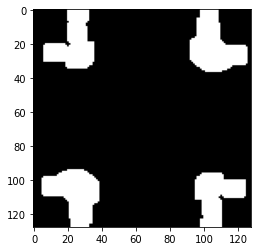

x_clean: 


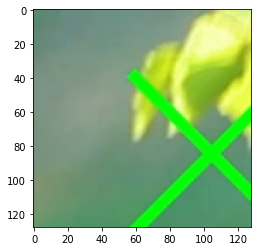

x_filmed: 


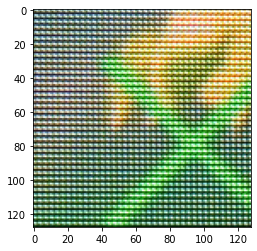

u_net_output orig: 


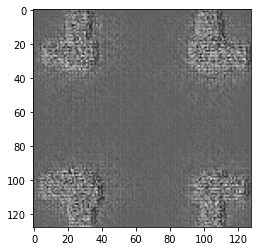

img_processed_r: 


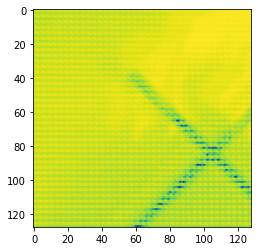

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image_processed_rgb: 


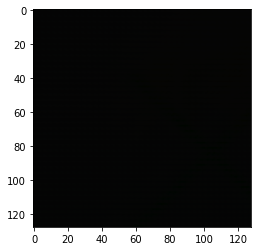

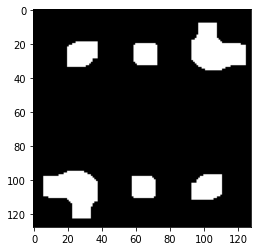

x_clean: 


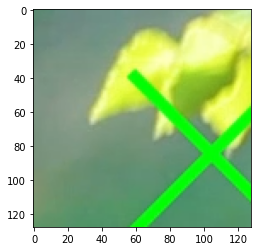

x_filmed: 


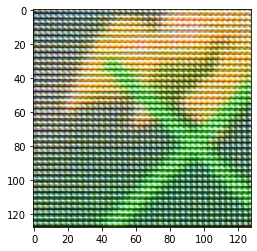

u_net_output orig: 


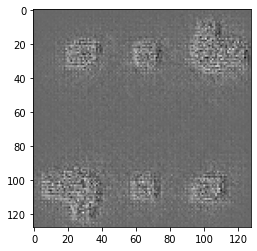

img_processed_r: 


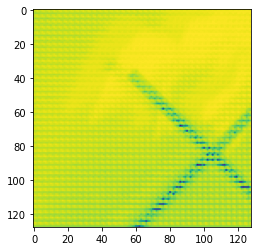

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image_processed_rgb: 


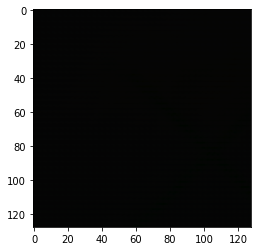

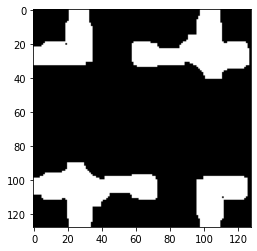

x_clean: 


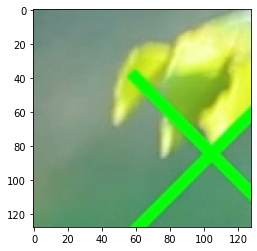

x_filmed: 


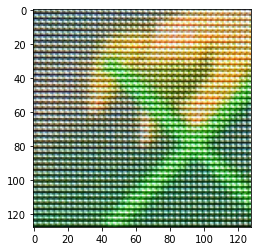

u_net_output orig: 


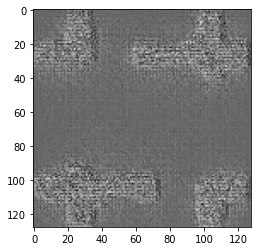

img_processed_r: 


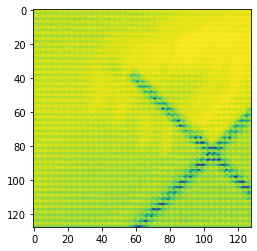

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image_processed_rgb: 


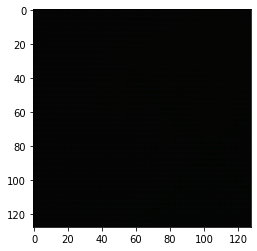

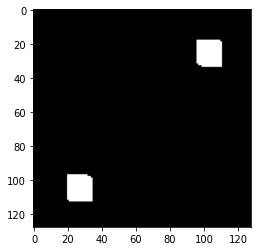

x_clean: 


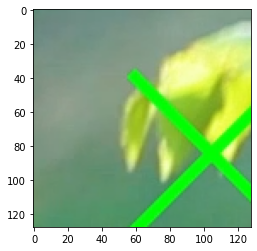

x_filmed: 


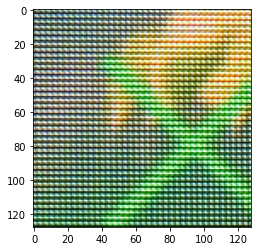

u_net_output orig: 


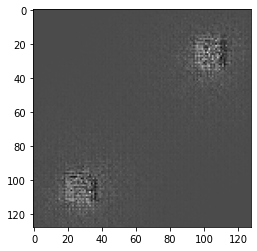

img_processed_r: 


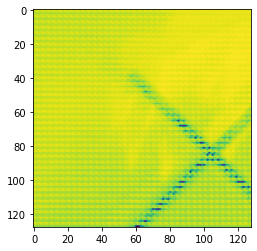

image_processed_rgb: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


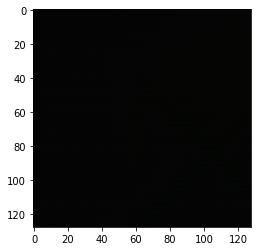

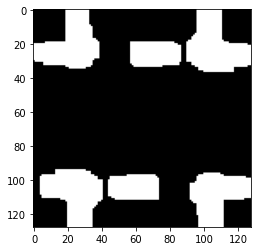

x_clean: 


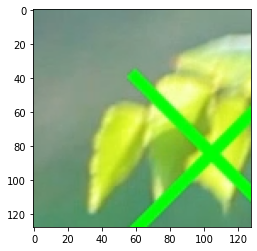

x_filmed: 


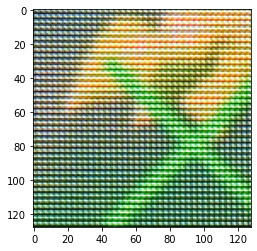

u_net_output orig: 


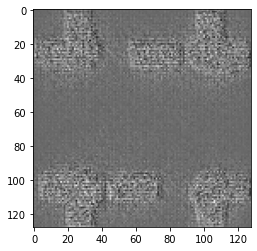

img_processed_r: 


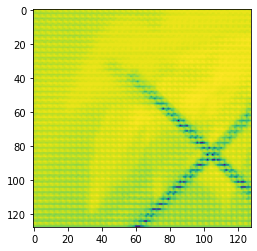

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image_processed_rgb: 


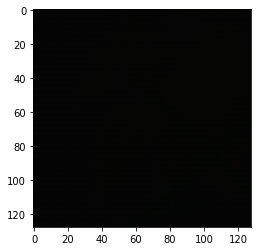

training...:   0%|                                  | 0/32 [00:07<?, ?it/s]

------------------------Am Ende angelangt, gehe in neue Epoche


ValueError: Floating point image RGB values must be in the 0..1 range.

In [1018]:
# Custom train loop

SAFE_RESULTS = True
WRITE_PATH = "D:\\Main\\MA_PROGR\\Data\\UNET_Output\\Session05"

show_intermediate_pics = True

RGB_WEIGHTS = [0.299, 0.587, 0.114]


overall_train_loss = []


execute_UNet_model = tf.function(model_u_net)
execute_cnn_model = tf.function(model_cnn)
execute_postprocessing_model = tf.function(postprocessing_model)

NUM_EPOCHS = 1
batch_size_cnn = 1
batch_size_unet = 32


optimizer = tf.keras.optimizers.Adam()
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn = tf.keras.losses.MeanAbsoluteError()
# loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
epoch_loss = tf.keras.metrics.MeanAbsoluteError()
# epoch_loss = tf.keras.metrics.SparseCategoricalAccuracy()
# epoch_loss = tf.keras.metrics.SparseCategoricalCrossentropy()

train_writer = tf.summary.create_file_writer("u_net_logs/train/")
test_writer = tf.summary.create_file_writer("u_net_logs/test/")

y_true = tf.constant(0, dtype=tf.float16, name="y_true")

jump_to_new_epoch = False

for epoch in range(NUM_EPOCHS):

    print(f"Start of epoch {epoch}")
    jump_to_new_epoch = False

    # Mache neue Generater, sodass wieder durch alle Bilder durchgegange wird für die nächste Epoche:
    train_filmed_img_gen_obj = my_train_filmed_gen()
    train_clean_img_gen_obj = my_train_clean_gen()

    # ---------------------------------------------------------------------------- BATCHES SAMMELN Start ----------------------------------------------------------------------------------------
    train_step = 0

    for batch_idx in tqdm(range(batch_size_unet), desc="training...", ascii=False, ncols=75):
        print("next batch...")
        cnn_mean_prediction_values = []

        with tf.GradientTape() as tape:

        
            # Bilder für den nächsten Batch sammeln:
            for i in range(batch_size_unet):
                try:
                    x_filmed = train_filmed_img_gen_obj.__next__()
                    x_clean = train_clean_img_gen_obj.__next__()
                except StopIteration as e:
                    print("------------------------Am Ende angelangt, gehe in neue Epoche")

                    jump_to_new_epoch = True

                if jump_to_new_epoch == True:
                    # Alle Bilder sind aufgebraucht, gehe in neue Epoche
                    break


                
                y_pred, differenzbild_fourier_px, u_net_output, image_processed_rgb = calc_mean_alias_value_of_one_image(
                    x_filmed, x_clean)
                cnn_mean_prediction_values.append(y_pred)

                # print("y_pred: ")
                # print(y_pred)

                # ---------------------------------------------------------------------------- BATCHES SAMMELN ENDE ----------------------------------------------------------------------------------------

            
            if SAFE_RESULTS:
                plt.imsave(f"{WRITE_PATH}\\x_filmed_{epoch}_{batch_idx}.png", x_filmed)

                plt.imsave(f"{WRITE_PATH}\\differenzbild_{epoch}_{batch_idx}.png",
                   differenzbild_fourier_px.reshape((IMG_WIDTH,IMG_HEIGHT)), cmap="gray")

                plt.imsave(f"{WRITE_PATH}\\unet_output_{epoch}_{batch_idx}.png",
                   u_net_output, cmap="gray")


                # Umformen in Numpy-Array
                image_processed_rgb = np.array(image_processed_rgb).reshape((IMG_WIDTH, IMG_HEIGHT, 3))

                # Max-Wert liegt manchesmal über 1 (keine ahnung warum...)
                if image_processed_rgb.max() >= 1:
                    # Werte auf 0 - 1 bringen
                    image_processed_rgb= image_processed_rgb / image_processed_rgb.max()


                plt.imsave(f"{WRITE_PATH}\\image_processed_rgb_{epoch}_{batch_idx}.png",
                   np.array(image_processed_rgb).reshape((IMG_WIDTH, IMG_HEIGHT, 3)))

            if jump_to_new_epoch == True:
                # Alle Bilder sind aufgebraucht, gehe in neue 
                break

            # ----------- Calc loss -----------

            y_true = tf.zeros(batch_size_unet, 1)

            # print("cnn_mean_prediction_values.shape: ")
            # print( np.array(cnn_mean_prediction_values).shape)

            loss = loss_fn(y_true=y_true, y_pred=cnn_mean_prediction_values)
            # print("loss: ")
            # print(loss)

            gradients = tape.gradient(loss, model_u_net.trainable_weights)
            del cnn_mean_prediction_values[:]
            # print("gradients: ")
            # print(gradients)

            # Optimize the model:
            optimizer.apply_gradients(
                zip(gradients, model_u_net.trainable_variables))

            tmp = epoch_loss.update_state(y_true, y_pred)

            # print("tmp")
            # print(tmp)


            # print("------------------------------------")
            # print("y_true:")
            # print(y_true)

            # print("y_pred")
            # print(y_pred)
            # print("------------------------------------")



            # with train_writer.as_default():
            #     tf.summary.scalar("Loss", loss, step=train_step)
            #     tf.summary.scalar(
            #         "Accuracy", epoch_loss.result(), step=train_step,
            #     )
            # train_step += 1
        
        # End Epoch

        print(f"--------------- epoch_loss: {epoch_loss.result()}")
        overall_train_loss.append(epoch_loss.result())



# overall_train_loss = epoch_loss.result()
# print(f"overall_train_loss: {overall_train_loss}")
# epoch_loss.reset_states()


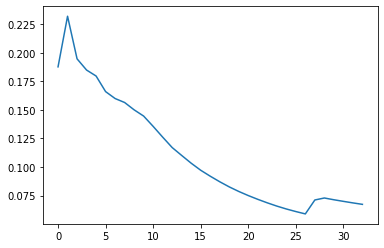

In [ ]:

plt.plot(overall_train_loss)

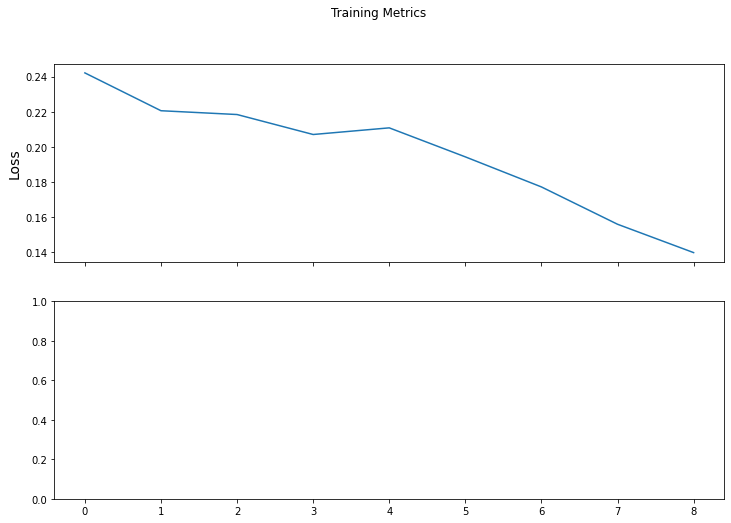

In [ ]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(overall_train_loss)

plt.show()


In [ ]:
test_img = img[400:528, 400:528,:]
test_img = np.array(test_img).reshape(1, 128 , 128 , 3)

# plt.imshow(test_img)

test_img= tf.convert_to_tensor(test_img, dtype=tf.float32)

test_img


ValueError: cannot reshape array of size 65536 into shape (1,128,128,3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


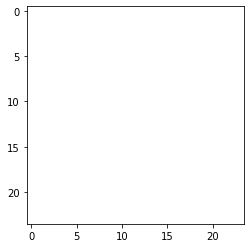

In [ ]:
import tensorflow as tf
BATCH_SIZE = 1
NUM_BOXES = 3
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
CHANNELS = 3
CROP_SIZE = (24, 24)

test_img = img[400:528, 400:528, :]
test_img = np.array(test_img).reshape(1, 128, 128, 3)

# plt.imshow(test_img)

test_img = tf.convert_to_tensor(test_img, dtype=tf.float32)
image = test_img
boxes = tf.random.uniform(shape=(NUM_BOXES, 4))
# plt.imshow(np.array(image).reshape(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
# plt.show()
box_indices = tf.random.uniform(shape=(NUM_BOXES,), minval=0,
                                maxval=BATCH_SIZE, dtype=tf.int32)
output = tf.image.crop_and_resize(image, boxes, box_indices, CROP_SIZE)
output.shape  # => (5, 24, 24, 3)

plt.imshow(output[2])
